# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [ ]:
DATA_DIR = '/content'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

## Download and extract files

In [ ]:
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
  if path.exists(pth) == False:
    os.mkdir(pth)

In [ ]:
#only run this cell once, at the start
import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [ ]:
!unzip "/content/train/train.zip" -d "/content/train/"
!unzip "/content/test/test.zip" -d "/content/test/"

Archive:  /content/train/train.zip
  inflating: /content/train/client_train.csv  
  inflating: /content/train/invoice_train.csv  
Archive:  /content/test/test.zip
  inflating: /content/test/client_test.csv  
  inflating: /content/test/invoice_test.csv  


# Data Prep

## Import Libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# machine learning
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import (
    classification_report,
    confusion_matrix)
    
import warnings
warnings.simplefilter('ignore')

## Read the Data

In [4]:
client_train = pd.read_csv('train/client_train.csv', low_memory=False)
invoice_train = pd.read_csv('train/invoice_train.csv', low_memory=False)

client_test = pd.read_csv('test/client_test.csv', low_memory=False)
invoice_test = pd.read_csv('test/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('SampleSubmission.csv', low_memory=False)

## Data Understanding

In [5]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [6]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [7]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [ ]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [ ]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [ ]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [ ]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [ ]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [ ]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [ ]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

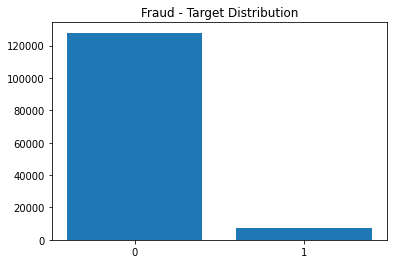

In [ ]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

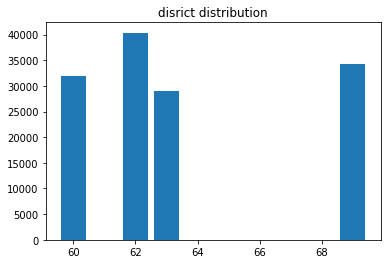

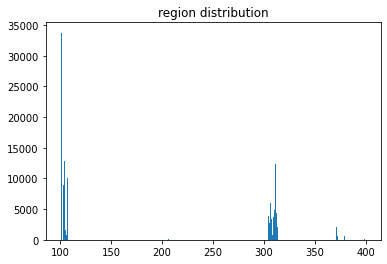

In [ ]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [8]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [9]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [10]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [11]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [12]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [13]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [14]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [15]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [16]:
train.shape, test.shape

((135493, 11), (58069, 10))

In [17]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [18]:
train.head()

,disrict,client_catg,region,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,11,101,0.0,35,352.400000,10.571429,0.000000,0.000000
1,69,11,107,0.0,37,557.540541,0.000000,0.000000,0.000000
2,62,11,301,0.0,18,798.611111,37.888889,0.000000,0.000000
3,69,11,105,0.0,20,1.200000,0.000000,0.000000,0.000000
4,62,11,303,0.0,14,663.714286,104.857143,117.357143,36.714286


# Modelling

## Train LGBM *Classifier*

In [52]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [53]:
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: num_iterationss


LGBMClassifier(num_iterationss=500)

In [ ]:
x_train.disrict.unique()

In [39]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

X = train.drop(columns=['target'])
y = train['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [100],
    'class_weight': ['balanced']
}

# Instantiate the LGBMClassifier: lgb_cl
lgb_cl = lgb.LGBMClassifier(random_state=123)

# Instantiate GridSearchCV
grid_search = GridSearchCV(lgb_cl, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions
best_lgb_cl = grid_search.best_estimator_
preds = best_lgb_cl.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

Best Parameters: {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.637256


## xgboost

In [85]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = train.drop(columns=['target'])
y = train['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [100]
#     'scale_pos_weight': [1, 2, 'balanced']
}

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', random_state=123)

# Instantiate GridSearchCV
grid_search = GridSearchCV(xg_cl, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions
best_xg_cl = grid_search.best_estimator_
preds = best_xg_cl.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.942876


In [96]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler

# Assuming imbalance_ratio is defined
imbalance_ratio = 2  # Replace with your actual imbalance ratio

X = train.drop(columns=['target'])
y = train['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Oversampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', random_state=123)

# Fit the model using GridSearchCV with oversampled data
xg_cl.fit(X_train_over, y_train_over)

# Use the best model to make predictions
preds = xg_cl.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

Accuracy: 0.724086


## LogisticRegression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform
from sklearn.metrics import accuracy_score

X = train.drop(columns=['target'])
y = train['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# create the models
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the data to the model
logreg.fit(X_train, y_train)

# Get predicted probabilities instead of hard predictions
predicted_probabilities = logreg.predict_proba(X_test)[:, 1]

preds = logreg.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("accuracy: %f" % (accuracy))

accuracy: 0.649138


## RandomForestClassifier

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = train.drop(columns=['target'])
y = train['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the RandomForestClassifier
rf_cl = RandomForestClassifier(n_estimators=100, 
                               max_depth=3, 
#                                class_weight='balanced', 
                               random_state=123)

# Fit the model to the training data
rf_cl.fit(X_train, y_train)

# Make predictions on the test data
preds = rf_cl.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

Accuracy: 0.942876


## CatBoost classifier

In [38]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = train.drop(columns=['target'])
y = train['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the CatBoostClassifier with balanced class weights
cat_clf = CatBoostClassifier(iterations=100, 
                             depth=3, 
                             learning_rate=0.1, 
                             random_seed=123)

# Fit the model to the training data
cat_clf.fit(X_train, y_train)

# Make predictions on the test set
preds = cat_clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %f" % accuracy)

0:	learn: 0.6178700	total: 159ms	remaining: 15.8s
1:	learn: 0.5561977	total: 171ms	remaining: 8.39s
2:	learn: 0.5049805	total: 182ms	remaining: 5.9s
3:	learn: 0.4622187	total: 198ms	remaining: 4.75s
4:	learn: 0.4257689	total: 212ms	remaining: 4.03s
5:	learn: 0.3949866	total: 229ms	remaining: 3.59s
6:	learn: 0.3684172	total: 243ms	remaining: 3.23s
7:	learn: 0.3455946	total: 256ms	remaining: 2.94s
8:	learn: 0.3261061	total: 271ms	remaining: 2.74s
9:	learn: 0.3092462	total: 282ms	remaining: 2.54s
10:	learn: 0.2948894	total: 296ms	remaining: 2.39s
11:	learn: 0.2823967	total: 308ms	remaining: 2.25s
12:	learn: 0.2712772	total: 322ms	remaining: 2.16s
13:	learn: 0.2616047	total: 335ms	remaining: 2.06s
14:	learn: 0.2534088	total: 350ms	remaining: 1.98s
15:	learn: 0.2461086	total: 369ms	remaining: 1.94s
16:	learn: 0.2397293	total: 399ms	remaining: 1.95s
17:	learn: 0.2343238	total: 410ms	remaining: 1.87s
18:	learn: 0.2293821	total: 423ms	remaining: 1.8s
19:	learn: 0.2251756	total: 443ms	remaining

## Make Predictions on test set

In [ ]:
test.columns

Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')

In [60]:
test.head()

,disrict,client_catg,region,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,62,11,307,37,488.135135,3.243243,0.000000,0.000000
1,69,11,103,22,1091.409091,843.136364,182.318182,586.318182
2,62,11,310,74,554.040541,37.364865,15.743243,0.162162
3,60,11,101,40,244.350000,0.000000,0.000000,0.000000
4,62,11,301,53,568.188679,145.056604,33.679245,0.000000


In [68]:
preds = logreg.predict_proba(test)[:, 1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.469253
1,0.490350
2,0.684001
3,0.501559
4,0.585874


In [97]:
preds = xg_cl.predict_proba(test)[:, 1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.589424
1,0.596670
2,0.574667
3,0.383346
4,0.327784


In [86]:
preds = best_xg_cl.predict_proba(test)[:, 1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.058923
1,0.189519
2,0.103643
3,0.041232
4,0.060110


In [81]:
preds = rf_cl.predict_proba(test)[:, 1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.062815
1,0.124578
2,0.115328
3,0.041668
4,0.082980


In [77]:
preds = cat_clf.predict_proba(test)[:, 1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.057319
1,0.185789
2,0.089134
3,0.036216
4,0.072647


In [62]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.057954
1,0.205179
2,0.067870
3,0.040103
4,0.047216


In [98]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.589424
1,test_Client_1,0.596670
2,test_Client_10,0.574667
3,test_Client_100,0.383346
4,test_Client_1000,0.327784


In [99]:
submission.to_csv('submission_xg_cl_balanced.csv', index=False)

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************